# **Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

## **Edición 2023**


----

# Trabajo práctico entregable - parte 2


En el ejercicio 1 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad. Además de ello, tuvieron que reducir el número de valores posibles para las variables categóricas utilizando información de dominio.

En el ejercicio 2 de la parte 1 del entregable imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`. (DISCLAIMER: Laura Minuet aclaró por slack que esta consigna es obsoleta)

En esta notebook, **se utilizará resultado de dichas operaciones.**


In [1]:
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
import seaborn as sns
sns.set_context('talk')

In [2]:
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

#melb_df_2=pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')

## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


**RESOLUCIÓN EJERCICIO 1**

Para el **enconding**, vamos aplicar filtro a las columnas ya analizadas en el entegrable 1, evitando así outliers de estas variables númericas. 
Por otro lado, tal como lo pide el ejercicio, exceptuaremos del dataframe a las columnas YearBuilt y BuildingArea. Sin embargo, las necesitaremos en el punto 2, por lo que las dejaremos almacenadas en otras columnas para que puedan ser agregadas a posteriori

In [3]:
melb_df = melb_df[ (melb_df['Rooms'] < 5) & (melb_df['Distance'] < 22 )& (melb_df['Car'] < 3)]
building_area= melb_df['BuildingArea']
year_built= melb_df['YearBuilt']
encode_melb_df = melb_df.drop(['Address','Method', 'Bedroom2', 'Date','SellerG','BuildingArea', 'YearBuilt'], axis=1)

Revisamos como se ve el nuevo dataframe

In [4]:
encode_melb_df.head()

,Suburb,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,2,h,1480000.0,2.5,3067.0,1.0,1.0,202.0,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,2,h,1035000.0,2.5,3067.0,1.0,0.0,156.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,3,h,1465000.0,2.5,3067.0,2.0,0.0,134.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,3,h,850000.0,2.5,3067.0,2.0,1.0,94.0,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,4,h,1600000.0,2.5,3067.0,1.0,2.0,120.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


Creamos una lista con las variables categóricas. Vamos a ver cuántos valores únicos tiene cada columna para tomar noción del incremento de las dimensiones del dataframe

In [5]:
#Creamos todas las categóricas
categorical_cols = ['Suburb', 'Type', 'CouncilArea', 'Regionname']
counter = 0

for category in categorical_cols:
  counter += encode_melb_df[category].nunique()

print(f'El nuevo dataframe con one-hot enconding tendrá {counter} columnas categóricas adicionales')


El nuevo dataframe con one-hot enconding tendrá 274 columnas categóricas adicionales


Revisaremos también si de estas variables hay celdas nulas. De todas maneras, esto no debería representar un problema. Serán filas que tendrán cero en todas las opciones disponibles para esa categoría

In [6]:
encode_melb_df[categorical_cols].isna().sum()

Suburb           0
Type             0
CouncilArea    911
Regionname       0
dtype: int64

Para crear las variables binarias lo haremos con el método get_dummies. 

In [7]:
suburb_df = pd.get_dummies(encode_melb_df['Suburb'],prefix='Suburb', drop_first = False)
type_df = pd.get_dummies(encode_melb_df['Type'],prefix='Type', drop_first = False)
council_area_df = pd.get_dummies(encode_melb_df['CouncilArea'],prefix='CouncilArea', drop_first = False)
regionname_df = pd.get_dummies(encode_melb_df['Regionname'],prefix='RegionName', drop_first = False)

La resolución de este ejercicio pide también la codificación en one-hot de las variables numéricas. Veamos cuales son las variables numéricas con posibilidad de selección y realizaremos el mismo conteo de ampliación de la dimensión que para las categóricas

In [8]:
numerical_cols = ['Rooms', 'Price', 'Distance', 'Postcode',
       'Bathroom', 'Car', 'Landsize', 'Lattitude',
       'Longtitude', 'Propertycount']

counter = 0

for category in numerical_cols:
  counter += encode_melb_df[category].nunique()

print(f'El nuevo dataframe con one-hot enconding tendrá {counter} columnas numéricas adicionales')

El nuevo dataframe con one-hot enconding tendrá 14952 columnas numéricas adicionales


Vemos que codificar en one-hot tendría un crecimiento inmenso. Asimismo, para la mayoría de las variables numéricas no tiene sentido pues -algunas además de ser contínuas- representan lo esperado sin una transformación one-hot. Pensemos en la columna Price por ejemplo

In [9]:
encode_melb_df['Price'].nunique()

1993

Aplicando one-hot a esta columna no solo estamos añadiendo más de 2mil nuevas columnas, si no que no reviste demasiado sentido. Es correcto que el precio se muestre de la manera en la que está. Luego se podría ponderar según más barato o más caro y la elección de las personas para comprarla. 

Por esta razón tomaremos cuatro columnas con hasta 7 valores únicos que puede ser importante representarlas en one-hot y que no añaden gran dimensionalidad (14 nuevas columnas)

In [10]:
print(encode_melb_df['Rooms'].nunique())
print(encode_melb_df['Bathroom'].nunique())
print(encode_melb_df['Car'].nunique())

4
7
3


Volvemos a usar get_dummies para el encoding

In [11]:
rooms_df = pd.get_dummies(encode_melb_df['Rooms'],prefix='Rooms', drop_first = False)
bathroom_df = pd.get_dummies(encode_melb_df['Bathroom'],prefix='Bathroom', drop_first = False)
car_df = pd.get_dummies(encode_melb_df['Car'], prefix='Car', drop_first=False)

Ahora vamos a añadir las nuevas columnas -que están en otros dataframes- al dataframe original. Luego, eliminaremos la columna original, que dio lugar al encoding.
Primero las columnas categóricas

In [12]:
# Añadimos las variables binarias al DataFrame
encode_melb_df = pd.concat([encode_melb_df, suburb_df, type_df, council_area_df, regionname_df], axis = 1)

# Eliminamos las columnas originales, que fueron reemplazadas por los encodings
encode_melb_df = encode_melb_df.drop(columns=['Suburb', 'Type', 'CouncilArea', 'Regionname'])

Hacemos lo propio con las columnas numéricas

In [13]:
# Añadimos las variables binarias al DataFrame
encode_melb_df = pd.concat([encode_melb_df, rooms_df, bathroom_df, car_df], axis = 1)

# Eliminamos las columnas originales, que fueron reemplazadas por los encodings
encode_melb_df = encode_melb_df.drop(columns=['Rooms', 'Bathroom', 'Car'])

Veamos como quedó el dataframe modificado

In [14]:
encode_melb_df.head()

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Bathroom_0.0,Bathroom_1.0,Bathroom_2.0,Bathroom_3.0,Bathroom_4.0,Bathroom_5.0,Bathroom_6.0,Car_0.0,Car_1.0,Car_2.0
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

<Axes: >

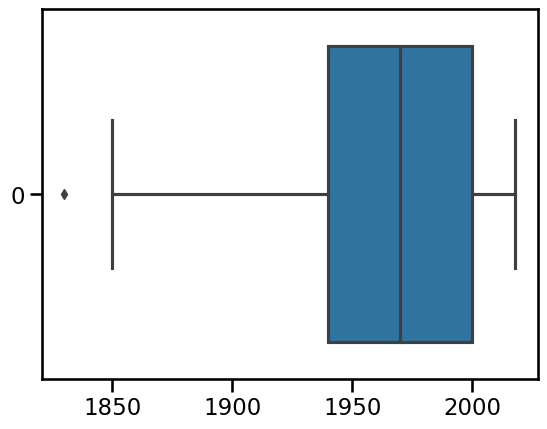

In [15]:
melb_pre_mice_df = encode_melb_df.copy(deep=True) #realizamos una copia del df del ejercicio 1
melb_pre_mice_df = pd.concat([melb_pre_mice_df,building_area,year_built], axis = 1) #agregamos las variables building area y year built que habíamos dejado de lado

sns.boxplot(melb_pre_mice_df['YearBuilt'] , orient = 'h') #outliers valores <= 1850

<Axes: >

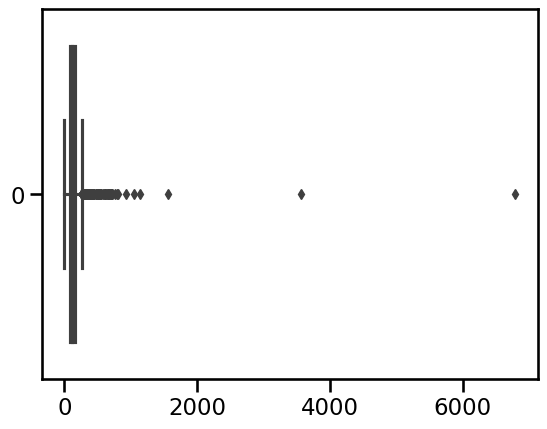

In [16]:
sns.boxplot(melb_pre_mice_df['BuildingArea'] , orient = 'h')

(-10.0, 500.0)

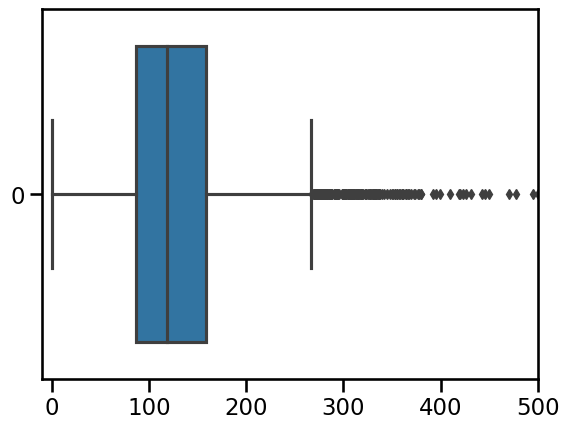

In [17]:
sns.boxplot(melb_pre_mice_df['BuildingArea'] , orient = 'h') #outliers valores > 300
plt.xlim(-10,500)

In [18]:
melb_reduced_pre_mice_df = melb_pre_mice_df.loc [ (melb_pre_mice_df['YearBuilt'] > 1850) & (melb_pre_mice_df['BuildingArea'] < 300 ) | pd.isna(melb_pre_mice_df['YearBuilt']) & pd.isna(melb_pre_mice_df['BuildingArea'])]
melb_reduced_pre_mice_df.head()

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Bathroom_2.0,Bathroom_3.0,Bathroom_4.0,Bathroom_5.0,Bathroom_6.0,Car_0.0,Car_1.0,Car_2.0,BuildingArea,YearBuilt
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,1,0,0,...,0,0,0,0,0,0,1,0,NaN,NaN
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,1,0,0,...,0,0,0,0,0,1,0,0,79.0,1900.0
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,1,0,0,...,1,0,0,0,0,1,0,0,150.0,1900.0
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,1,0,0,...,1,0,0,0,0,0,1,0,NaN,NaN
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,1,0,0,...,0,0,0,0,0,0,0,1,142.0,2014.0


In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

melb_mice_df = melb_reduced_pre_mice_df.copy()
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_mice_df[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_mice_df[['YearBuilt', 'BuildingArea']])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Ejemplo de gráfico comparando las distribuciones de datos obtenidas con cada método de imputación:

(1800.0, 2048.321143822655)

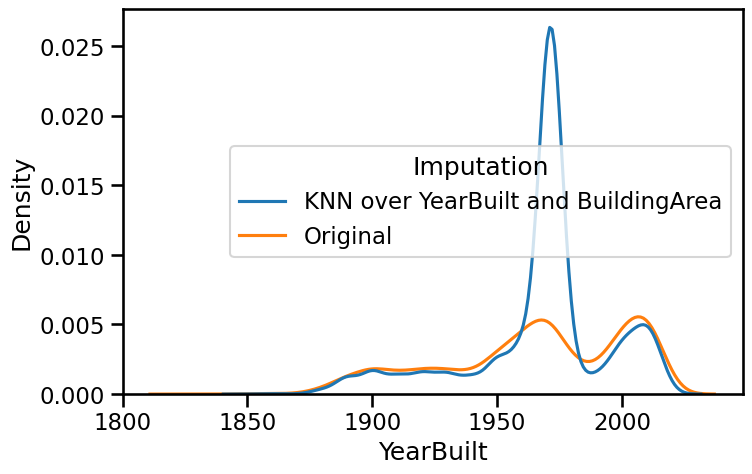

In [20]:
mice_year_built = melb_mice_df.YearBuilt.to_frame()
mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_year_build = melb_df.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data1 = pd.concat([mice_year_built, melb_year_build])

fig = plt.figure(figsize=(8, 5))
g1 = sns.kdeplot(data=data1, x='YearBuilt', hue='Imputation')
plt.xlim(1800,None)

(-200.0, 600.0)

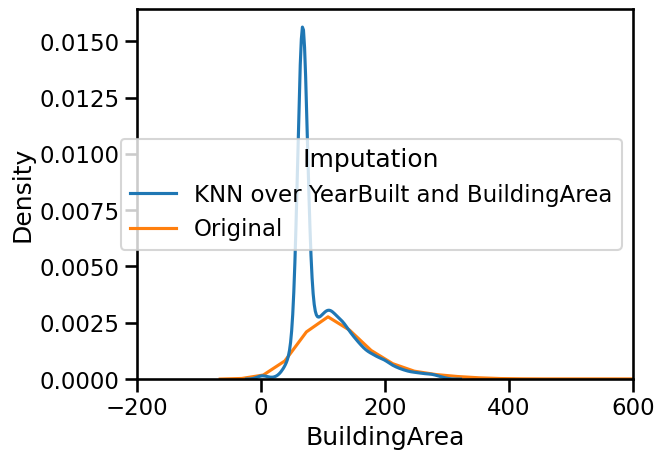

In [21]:
mice_build_area = melb_mice_df.BuildingArea.to_frame()
mice_build_area['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_build_area = melb_df.BuildingArea.dropna().to_frame()
melb_build_area['Imputation'] = 'Original'
data2 = pd.concat([mice_build_area, melb_build_area])

g2 = sns.kdeplot(data=data2, x='BuildingArea', hue='Imputation')
plt.xlim(-200,600)


Como se puede observar al analizar las variables, los valores de BuildingArea son muy distintos a los de YearBuilt. Por este motivo la imputación sin ningún procesamiento de las variables no es correcta. Por eso, primero deben escalarse o normalizarse los datos. Comenzaremos probando el escalamiento de los mismos:

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Copiamos el DF original
melb_scaled_df = melb_reduced_pre_mice_df.copy(deep=True) #realizamos una copia del df que teníamos antes de aplicar la imputación

# Creamos un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustamos y transformamos los datos
scaled_columns=['YearBuilt','BuildingArea']
melb_scaled_df[scaled_columns] = scaler.fit_transform(melb_scaled_df[scaled_columns])

melb_scaled_df.sample(20)


,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Bathroom_2.0,Bathroom_3.0,Bathroom_4.0,Bathroom_5.0,Bathroom_6.0,Car_0.0,Car_1.0,Car_2.0,BuildingArea,YearBuilt
8844,390000.0,14.0,3047.0,165.0,-37.68582,144.91638,851.0,0,0,0,...,0,0,0,0,0,0,1,0,0.298447,0.859756
10490,1341000.0,2.4,3121.0,135.0,-37.82241,145.00235,14949.0,0,0,0,...,0,0,0,0,0,1,0,0,0.291741,0.219512
9341,520000.0,10.5,3020.0,535.0,-37.79414,144.81855,6763.0,0,0,0,...,1,0,0,0,0,0,0,1,NaN,NaN
7108,967500.0,7.8,3012.0,325.0,-37.81200,144.88040,1808.0,0,0,0,...,0,0,0,0,0,0,1,0,NaN,NaN
10142,590000.0,16.1,3088.0,392.0,-37.70433,145.12184,1390.0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
280,567000.0,6.3,3143.0,0.0,-37.85490,145.01130,4836.0,0,0,0,...,0,0,0,0,0,0,1,0,0.177727,0.969512
11044,565000.0,11.2,3046.0,193.0,-37.70612,144.91440,8870.0,0,0,0,...,0,0,0,0,0,0,0,1,0.352101,0.859756
9701,780000.0,12.0,3073.0,893.0,-37.69964,145.00945,21650.0,0,0,0,...,0,0,0,0,0,0,0,1,0.345394,0.524390
9754,1208000.0,17.2,3133.0,785.0,-37.86343,145.18542,4280.0,0,0,0,...,1,0,0,0,0,0,0,1,NaN,NaN
6330,1200000.0,6.5,3071.0,349.0,-37.75840,145.01150,8870.0,0,0,0,...,1,0,0,0,0,0,0,1,NaN,NaN


In [23]:
melb_scaled_mice = melb_scaled_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_scaled_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_scaled_mice[['YearBuilt', 'BuildingArea']])

melb_scaled_mice.head()

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Bathroom_2.0,Bathroom_3.0,Bathroom_4.0,Bathroom_5.0,Bathroom_6.0,Car_0.0,Car_1.0,Car_2.0,BuildingArea,YearBuilt
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,1,0,0,...,0,0,0,0,0,0,1,0,0.468126,0.769512
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,1,0,0,...,0,0,0,0,0,1,0,0,0.264914,0.280488
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,1,0,0,...,1,0,0,0,0,1,0,0,0.503001,0.280488
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,1,0,0,...,1,0,0,0,0,0,1,0,0.468126,0.769512
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,1,0,0,...,0,0,0,0,0,0,0,1,0.476175,0.975610


Text(0.5, 0.98, 'Escaled data')

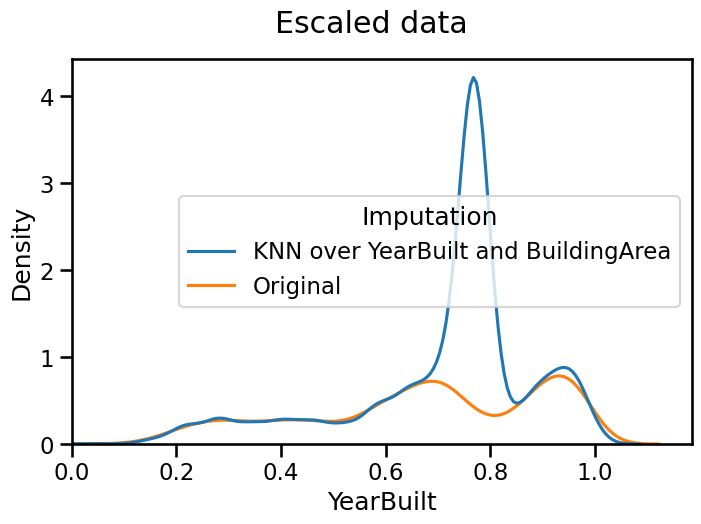

In [24]:
scaled_mice_year_built = melb_scaled_mice.YearBuilt.to_frame()
scaled_mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_scaled_year_built = melb_scaled_df.YearBuilt.dropna().to_frame()
melb_scaled_year_built['Imputation'] = 'Original'

data3 = pd.concat([scaled_mice_year_built, melb_scaled_year_built])

fig = plt.figure(figsize=(8, 5))
g3 = sns.kdeplot(data=data3, x='YearBuilt', hue='Imputation')
plt.xlim(0,None)
plt.suptitle('Escaled data')

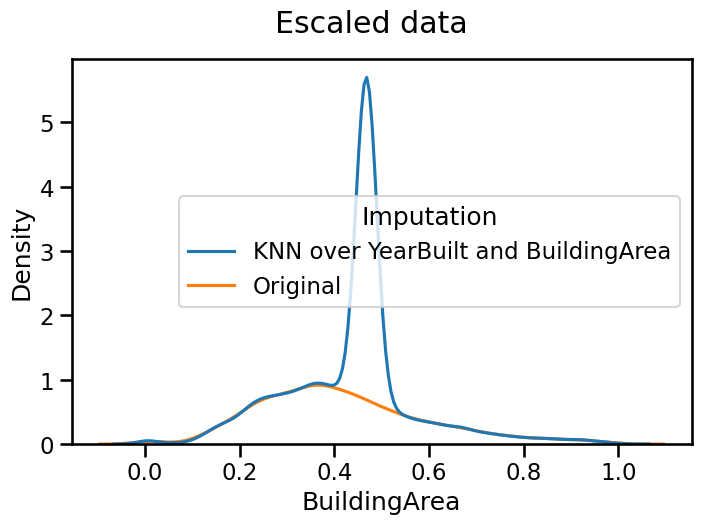

In [25]:
scaled_mice_build_area = melb_scaled_mice.BuildingArea.to_frame()
scaled_mice_build_area['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_scaled_build_area = melb_scaled_df.BuildingArea.dropna().to_frame()
melb_scaled_build_area['Imputation'] = 'Original'

data4 = pd.concat([scaled_mice_build_area, melb_scaled_build_area])

fig = plt.figure(figsize=(8, 5))
plt.suptitle('Escaled data')
g4 = sns.kdeplot(data=data4, x='BuildingArea', hue='Imputation')
plt.show()

Ahora probaremos con el normalizado de los datos antes de la imputación:

In [26]:
from sklearn.preprocessing import StandardScaler

# Copiamos el DF original
melb_normal_df = melb_reduced_pre_mice_df.copy(deep=True) #realizamos una copia del df que teníamos antes de aplicar la imputación

# Creamos un objeto MinMaxScaler
scaler2 = StandardScaler()

# Ajustamos y transformamos los datos
normalized_columns=['YearBuilt','BuildingArea']
melb_normal_df[normalized_columns] = scaler2.fit_transform(melb_normal_df[normalized_columns])

melb_normal_df.head()

,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Bathroom_2.0,Bathroom_3.0,Bathroom_4.0,Bathroom_5.0,Bathroom_6.0,Car_0.0,Car_1.0,Car_2.0,BuildingArea,YearBuilt
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,1,0,0,...,0,0,0,0,0,0,1,0,NaN,NaN
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,1,0,0,...,0,0,0,0,0,1,0,0,-0.852779,-1.713057
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,1,0,0,...,1,0,0,0,0,1,0,0,0.485163,-1.713057
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,1,0,0,...,1,0,0,0,0,0,1,0,NaN,NaN
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,1,0,0,...,0,0,0,0,0,0,0,1,0.334409,1.329277


In [27]:
melb_normal_mice = melb_normal_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_normal_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_normal_mice[['YearBuilt', 'BuildingArea']])

melb_normal_mice.head()

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Price,Distance,Postcode,Landsize,Lattitude,Longtitude,Propertycount,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,...,Bathroom_2.0,Bathroom_3.0,Bathroom_4.0,Bathroom_5.0,Bathroom_6.0,Car_0.0,Car_1.0,Car_2.0,BuildingArea,YearBuilt
0,1480000.0,2.5,3067.0,202.0,-37.7996,144.9984,4019.0,1,0,0,...,0,0,0,0,0,0,1,0,0.601997,0.763509
1,1035000.0,2.5,3067.0,156.0,-37.8079,144.9934,4019.0,1,0,0,...,0,0,0,0,0,1,0,0,-0.852779,-1.713057
2,1465000.0,2.5,3067.0,134.0,-37.8093,144.9944,4019.0,1,0,0,...,1,0,0,0,0,1,0,0,0.485163,-1.713057
3,850000.0,2.5,3067.0,94.0,-37.7969,144.9969,4019.0,1,0,0,...,1,0,0,0,0,0,1,0,0.601997,0.763509
4,1600000.0,2.5,3067.0,120.0,-37.8072,144.9941,4019.0,1,0,0,...,0,0,0,0,0,0,0,1,0.334409,1.329277


Text(0.5, 0.98, 'Normalized data')

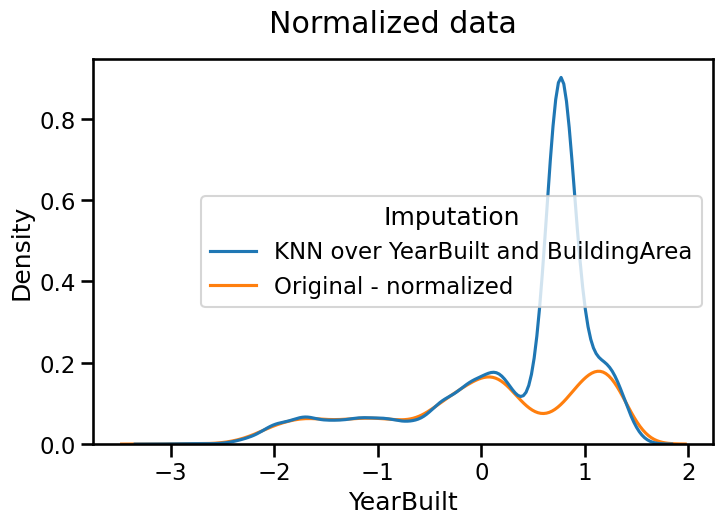

In [28]:
normal_mice_year_built = melb_normal_mice.YearBuilt.to_frame()
normal_mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_normal_year_built = melb_normal_df.YearBuilt.dropna().to_frame()
melb_normal_year_built['Imputation'] = 'Original - normalized'

data5 = pd.concat([normal_mice_year_built, melb_normal_year_built])

fig = plt.figure(figsize=(8, 5))
g5 = sns.kdeplot(data=data5, x='YearBuilt', hue='Imputation')
plt.suptitle('Normalized data')

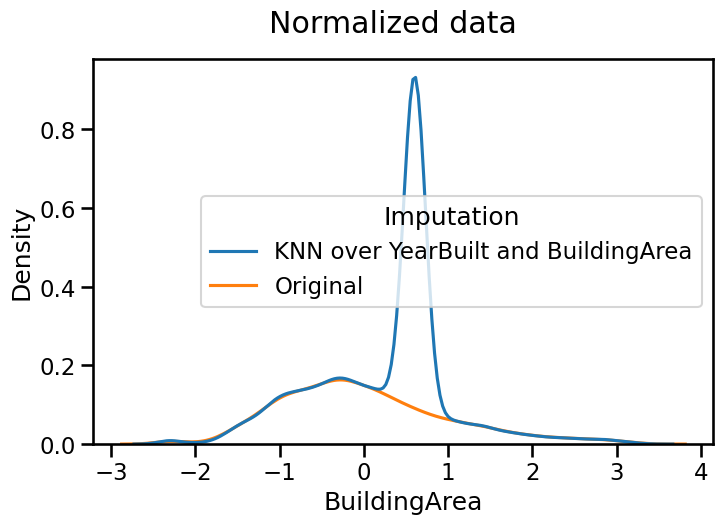

In [29]:
normal_mice_build_area = melb_normal_mice.BuildingArea.to_frame()
normal_mice_build_area['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_normal_build_area = melb_normal_df.BuildingArea.dropna().to_frame()
melb_normal_build_area['Imputation'] = 'Original'

data6 = pd.concat([normal_mice_build_area, melb_normal_build_area])

fig = plt.figure(figsize=(8, 5))
plt.suptitle('Normalized data')
g6 = sns.kdeplot(data=data6, x='BuildingArea', hue='Imputation')
plt.show()

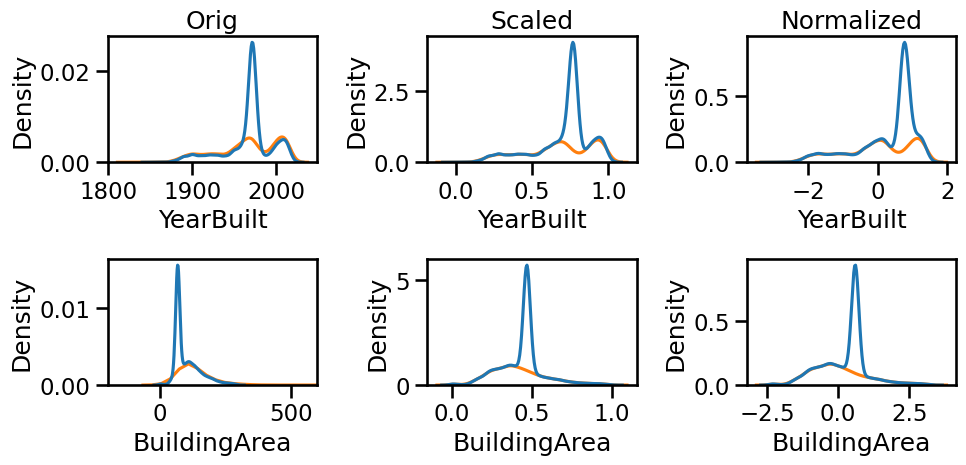

In [30]:
# Veamos todos los gráficos juntos
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Trazar los gráficos de densidad en cada subtrama
sns.kdeplot(data=data1, ax=axes[0, 0], x='YearBuilt', hue = 'Imputation')
axes[0, 0].set_title('Orig')
axes[0, 0].legend_.remove()

sns.kdeplot(data=data3, ax=axes[0, 1], x='YearBuilt', hue = 'Imputation')
axes[0, 1].set_title('Scaled')
axes[0, 1].legend_.remove()

sns.kdeplot(data=data5, ax=axes[0, 2], x='YearBuilt', hue = 'Imputation')
axes[0, 2].set_title('Normalized')
axes[0, 2].legend_.remove()

sns.kdeplot(data=data2, ax=axes[1, 0], x='BuildingArea', hue = 'Imputation')
axes[1, 0].legend_.remove()
axes[1, 0].set_xlim(-200, 600)

sns.kdeplot(data=data4, ax=axes[1, 1], x='BuildingArea', hue = 'Imputation')
axes[1, 1].legend_.remove()

sns.kdeplot(data=data6, ax=axes[1, 2], x='BuildingArea', hue = 'Imputation')
axes[1, 2].legend_.remove()

plt.tight_layout()




A partir de estos gráficos, podemos observar que el mayor cambio se da para la variable BuildingArea. En este caso, fue muy importante el tratar los datos previamente a la imputación, ya sea escalando o normalizando. Esto probablemente se debe a que los valores de esta variable son mucho menores que los de YearBuilt.






## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

In [31]:
melb_pca_df = melb_scaled_mice.copy(deep=True)
melb_pca_df.shape

(9685, 297)

Primero trabajamos con estandarización

In [32]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
stdandard_dense_feature_matrix = std_scaler.fit_transform(melb_pca_df)
np.max(stdandard_dense_feature_matrix), np.min(stdandard_dense_feature_matrix)

(98.40731680114034, -3.9866080311548395)

In [33]:
from sklearn.decomposition import PCA
pca_st = PCA(n_components=50) #Tomo un valor mayor a 20 que es lo que pide el ejercicio, pero mucho menor que 310, si veo en gráfico que no alcanza a bajar la varianza lo amplio
pca_st.fit(stdandard_dense_feature_matrix)
proyected_features_std = pca_st.transform(stdandard_dense_feature_matrix)
proyected_features_std.shape

(9685, 50)

Luego con la forma escalada

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_dense_feature_matrix = scaler.fit_transform(melb_pca_df)
np.max(scaled_dense_feature_matrix), np.min(scaled_dense_feature_matrix)

(1.0000000000000002, -1.0000000000000009)

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(scaled_dense_feature_matrix)
proyected_features = pca.transform(scaled_dense_feature_matrix)
proyected_features.shape

(9685, 50)

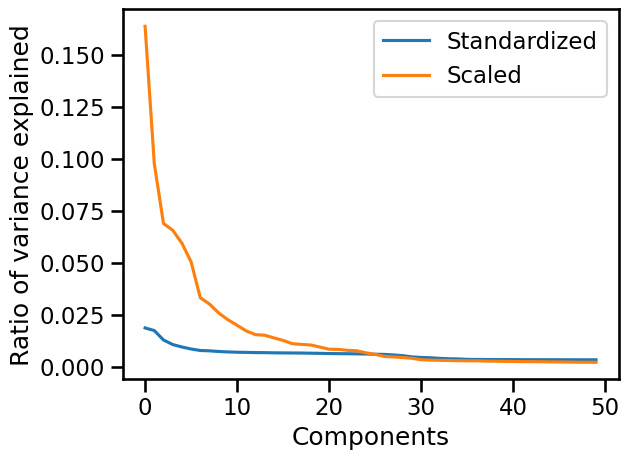

In [36]:
sns.lineplot(x=range(pca_st.n_components),
                 y=pca_st.explained_variance_ratio_, label='Standardized')
sns.lineplot(x=range(pca.n_components),
                 y=pca.explained_variance_ratio_, label='Scaled')
plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")
plt.legend()

El grafico nos dice que es mejor estandarizar ya que con menos de 10 componentes principales capturamos las variables componentes de mayor varianza, mientras que si solo escalamos necesitamos trabajar con al menos 20. Ampliaremos el Grafico para refinar la desición de cuantas PC elegir. 

(0.0, 10.0)

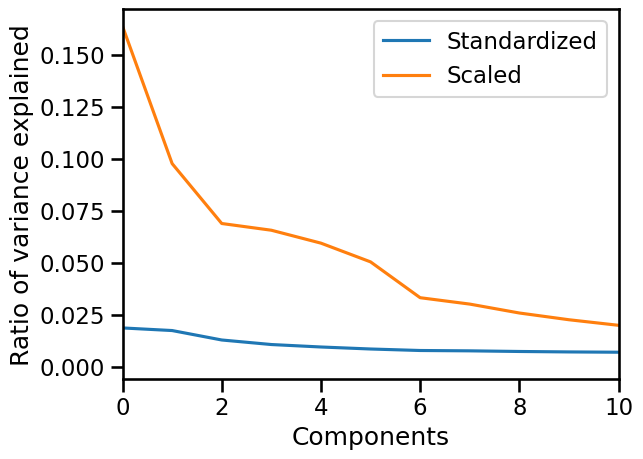

In [37]:
sns.lineplot(x=range(pca_st.n_components),
                 y=pca_st.explained_variance_ratio_, label='Standardized')
sns.lineplot(x=range(pca.n_components),
                 y=pca.explained_variance_ratio_, label='Scaled')
plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")
plt.legend()
plt.xlim(0,10)

Podriamos decir que con solo 2 PC podemos trabajar. 

<Axes: xlabel='pca1_standard', ylabel='pca2_standard'>

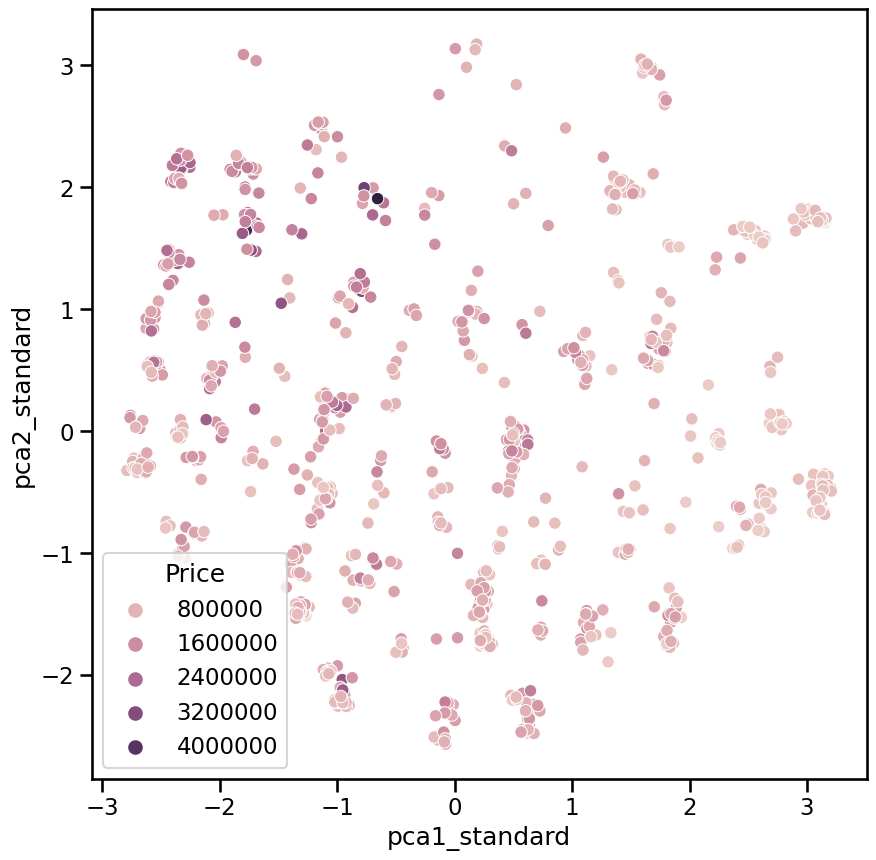

In [38]:
melb_pca_df[['pca1_standard', 'pca2_standard']] = proyected_features[:,:2]
data = melb_pca_df.sample(1000)
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=data, x='pca1_standard', y='pca2_standard',
                   hue='Price')  # 'Landsize' 'Price' 'YearBuilt'

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

Como veniamos trabajando con df lo que vamos hacer es una copia y el guardado del mismo en un archivo tipo csv

In [39]:
melb_df_curado= melb_pca_df.copy(deep=True)
melb_df_curado.to_csv("melb_df_curado.csv", index=None)
from google.colab import files
files.download('melb_df_curado.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```


La documentación se encuentra en un archivo que acompaña la entrega de esta notebook